# Image Classification using Logistic Regression on the Sign Language MNIST

This python script aims to construct an Image Classification model using Logistic Regression. The Sign Language MNIST dataset from [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) is used to train and evaluate the model. Each row in the csv file represents a label and a single 28x28 pixel image represented using 784 pixel values ranging from 0-255, much like the original MNIST dataset. However, the sign language MNIST only contains 27,455 cases for the training dataset and 7,172 cases for the test dataset which are much fewer as compared to the original MNIST.

The label in the dataset denotes a number ranging from 0-25 to represent its english letter equivalent (e.g. 0 = a). However, there is no label match for the letters "J" and "Z" due to the motion required to denote the letter.

## First let's install the necessary libraries for the script to work. 

This assumes that you are working in anaconda. The pytorch and torchvision libraries are for the machine learning functions. On the other hand, Pandas and Numpy are used for data handling while Matplotlib is for data/image visualization. The jovian library is used to save the notebook to the jovian.ml platform.

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Imports
import torch
import jovian
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

<IPython.core.display.Javascript object>

The hyperparameters dictate how our model will behave in learning. The batch\_size parameter dictates how much of the data is being used at a time to train the model. Ideally, you would want to use all the data in one run to train the model. However, doing so would result to a higher processor memory needed to run. To address this, we can process the data in batches which would be much easier for the processor. On the other hand, the learning\_rate dictates how much we would adjust the model weight parameters. The input\_size is dictated by the image size (in this case a 28x28 pixel image). Lastly, the num\_classes tells how many labels are there. In this case, 26, one for each letter.

In [3]:
# Hyperparameters
batch_size = 256
learning_rate = 1e-5

# Other constants
input_size = 28*28
num_classes = 26

Let's load the training and testing dataset

In [4]:
import os
os.chdir('/kaggle/input/sign-language-mnist/')
dataset = pd.read_csv('sign_mnist_train.csv')
testdataset = pd.read_csv('sign_mnist_test.csv')
num_rows = dataset.shape[0]
# To map each label number to its corresponding letter
letters = dict(enumerate(string.ascii_uppercase))

In [5]:
dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Since the machine learning functions need separate numerical arrays for the input image and input label, we've constructed a helper function to split the dataset for easier implementation. Then we used this function to split the training dataset and testing dataset.

In [6]:
def dataframe_to_array(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

In [7]:
inputs_array, targets_array = dataframe_to_array(dataset)
testinputs_array, testtargets_array = dataframe_to_array(testdataset)

Let's look at the first entry of the training dataset. Since we know that the image is a 28x28 grayscale image, we first reshape the array to 28x28 then set the colormap to gray.

Letter:  D


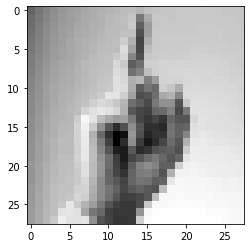

In [8]:
pic1 = np.reshape(inputs_array[0], (28, 28))
plt.imshow(pic1, cmap = "gray")
print("Letter: ", letters[targets_array[0].item()])

As expected, the image symbolizes "D". However, we can note that the image is not clear since the resolution is limited to 28x28. This may affect the accuracy of the model prediction especially when implementing at a much larger scale.

Let's start converting the training inputs and outputs and testing inputs and outputs to a tensor. Float is used as data type for the inputs for us to have more precision as compared to using discrete integers. On the other hand, long integer data type is used for the outputs since the output of our model are indices of the maximum likelihood function.

In [9]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).long()
testinputs = torch.from_numpy(testinputs_array).float()
testtargets = torch.from_numpy(testtargets_array).long()

In [10]:
# Logging parameters to Jovian.ml (Repository)
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········


[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
API KEY: ········
[jovian] Hyperparams logged.


## Dataset & Data loaders
#### After we have loaded and transformed the data to be used by the model. We then group these data in batches for the model to use.

First, let's wrap the training inputs and outputs to a single dataset for easier access and to ensure that the correct label is matched to its corresponding image. The same could also be done to the testing dataset. We then split the training dataset to training and validation subsets. 

After splitting the datasets, we then load these data in batches with size as we defined earlier. In this particular dataset, shuffling is not necessary since our dataset our not arranged by label. However, it is good practice to randomly shuffle the data to ensure that different batches of data are used in each training iteration which could help generalize the model and speed up the training process. Since the validation dataset are used to determine the accuracy of model, then shuffling is not necessary.

In [11]:
# Training validation & test dataset
dataset = TensorDataset(inputs, targets)
testdataset = TensorDataset(testinputs, testtargets)

# Let's use 15% of our training dataset to validate our model
val_percent = 0.15
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(testdataset, batch_size*2)

Letter:  I


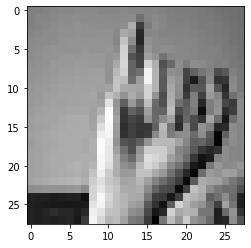

In [12]:
img, label = train_ds[0]
plt.imshow(img.reshape((28,28)), cmap = 'gray')
print("Letter: ", letters[label.item()])

As shown in the image, the first entry of our training dataset is not the same as the first entry of our dataframe earlier. From this, we have the assurance that entries in each batch of the dataset are randomized and different for each training iteration.

## Model
#### Let's then construct the model to predict the letter symbolized in the images

For our model, we'll use a logistic regression relating the input to the output. This is similar to a linear regression where various variables, with varying weights, and with offset bias affect the output. In this case each pixel value, multiplied by some value, added by some other value affects how the user perceive the letter denoted by the symbol.

We will use PyTorch's Linear Regression function but we will add more functions specific to our needs. Since PyTorch requires a one-dimentional input tensor, we will flatten the input to a tensor with shape (1, 784). The output of the Linear function is a tensor with 26 elements, with each value signifying the probability that the image denotes the letter corresponding to the index. For example the output is, \[0.001 0.001 ... 0.0\], then there is a 0.001 chance that the image symbolizes "A".

Upon instantiating the model, random weights and biases are generated in the initialization of the class. The forward method of the class is automatically run when a batch of data is passed on to the model.

Ideally, we want the output of the Linear function to be a tensor that contains probabilities. However, that is not initially the case since the output value ranges from negative to positive infinity (technically not infinity due to limitations in byte representations of numbers). Hence, we have a loss function that scales the values to within 0.0 to 1.0 and the sum of these values add up to 1. 

PyTorch's cross_entropy function implements the softmax function to the tensor. Since, there is only one correct letter denoted per image (hand letter symbols are unique), the softmax function is used as compared to the sigmoid function.

The validation\_step, validation\_epoch\_end, and epoch\_end method enable us to tell how our model is doing. For us users, we rely on the accuracy function (how often the model correctly predicts the image) to tell how good the model is. However, we can not tell how good the model performs every after iteration of the training_step. As such, the cross\_entropy function provides as an idea how the probability distribution for the function changes. Generally, we want lower val\_loss and higher val\_acc. The cross\_entropy function also enables us to perform gradient which enables us to adjust our model.

In [13]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

## Training
#### Initially, the model would have a low accuracy since it only contains random weights and biases for the input parameters. As such, we should train the model to lower the loss and increase the accuracy.

Here, we define accuracy as the amount of times the model correctly predicts the letter denoted by the hand image. Since we're dealing with probability distribution, we take the one with the highest probability to be the model's letter prediction.

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The evaluate helper function enables us to run the model to predict the letters in the validation dataset. It then returns the loss and accuracy in each iteration. 

The bulk of training of our model relies on the fit function. Here we define epoch as the amount of iterations we're training the model. The optimizer function used in this model is the Stochastic Gradient Descent of PyTorch. We aim to adjust the model parameters such that we reach the local minima of the fitting graph to minimize the loss. This optimizer function adjusts the parameters of the model by a factor dictated by the learning rate. After every adjustment/step, it is important to call the zero\_grad( ) method to reset gradient from calling the backward( ) method of the loss function.

In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
evaluate(model, val_loader)

{'val_loss': 305.1435852050781, 'val_acc': 0.0}

As seen from the evaluation of our model, we have a very low accuracy and a fairly high loss. This is expected since the initial model parameters are just random numbers. We must then train this model using our fit helper function.

In [17]:
history = fit(50, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 373.6416, val_acc: 0.1165
Epoch [1], val_loss: 236.6631, val_acc: 0.2990
Epoch [2], val_loss: 212.8696, val_acc: 0.1477
Epoch [3], val_loss: 96.1996, val_acc: 0.3692
Epoch [4], val_loss: 138.2231, val_acc: 0.2458
Epoch [5], val_loss: 153.9159, val_acc: 0.1462
Epoch [6], val_loss: 128.0211, val_acc: 0.2826
Epoch [7], val_loss: 58.6046, val_acc: 0.3783
Epoch [8], val_loss: 59.8205, val_acc: 0.4061
Epoch [9], val_loss: 62.2000, val_acc: 0.3818
Epoch [10], val_loss: 60.6861, val_acc: 0.3701
Epoch [11], val_loss: 51.1591, val_acc: 0.4152
Epoch [12], val_loss: 80.4534, val_acc: 0.2678
Epoch [13], val_loss: 22.9606, val_acc: 0.5818
Epoch [14], val_loss: 69.7663, val_acc: 0.3669
Epoch [15], val_loss: 29.4665, val_acc: 0.5241
Epoch [16], val_loss: 25.3637, val_acc: 0.6042
Epoch [17], val_loss: 65.6871, val_acc: 0.2994
Epoch [18], val_loss: 52.9328, val_acc: 0.4651
Epoch [19], val_loss: 54.6305, val_acc: 0.5595
Epoch [20], val_loss: 17.6914, val_acc: 0.6931
Epoch [21], val_l

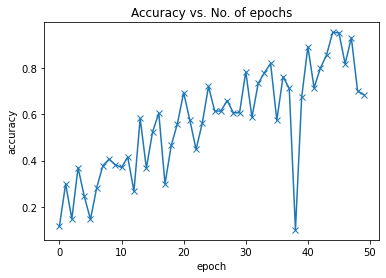

In [18]:
# Visualizing how our model performed after each epoch
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

From the graph, we can see that the our model somewhat improves as the amount of epoch increases. However, it can alo be seen that our model has a high variability. This may be due to a high learning rate. Let's try to test this model on the test dataset to see how it performed.

In [19]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 32.8629150390625, 'val_acc': 0.5368489623069763}

It has a low accuracy, just barely over 50%. Let's try to construct a new model with a lower learning rate and try to train it for the same number of epoch to see how the learning rate would affect the accuracy of the model.

In [20]:
model_2 = MnistModel()

In [21]:
# Evaluating the model prior to training
evaluate(model_2, val_loader)

{'val_loss': 206.95242309570312, 'val_acc': 0.04829545319080353}

Similarly, it also has a very low accuracy and high value loss. Let's train this model with the same number of epochs but a lower learning rate (1e-5).

In [22]:
history_2 = fit(50, 1e-5, model_2, train_loader, val_loader)

Epoch [0], val_loss: 30.3771, val_acc: 0.0865
Epoch [1], val_loss: 24.0372, val_acc: 0.1545
Epoch [2], val_loss: 19.4929, val_acc: 0.1840
Epoch [3], val_loss: 21.1964, val_acc: 0.2015
Epoch [4], val_loss: 15.6984, val_acc: 0.2415
Epoch [5], val_loss: 14.2188, val_acc: 0.3040
Epoch [6], val_loss: 14.0876, val_acc: 0.2671
Epoch [7], val_loss: 13.1219, val_acc: 0.3275
Epoch [8], val_loss: 13.9743, val_acc: 0.2624
Epoch [9], val_loss: 10.2435, val_acc: 0.3625
Epoch [10], val_loss: 9.8026, val_acc: 0.3652
Epoch [11], val_loss: 10.2683, val_acc: 0.3606
Epoch [12], val_loss: 10.2023, val_acc: 0.3878
Epoch [13], val_loss: 7.8090, val_acc: 0.4470
Epoch [14], val_loss: 7.2419, val_acc: 0.4401
Epoch [15], val_loss: 9.5957, val_acc: 0.3854
Epoch [16], val_loss: 10.0392, val_acc: 0.4118
Epoch [17], val_loss: 8.0192, val_acc: 0.4209
Epoch [18], val_loss: 5.7691, val_acc: 0.4953
Epoch [19], val_loss: 7.1530, val_acc: 0.4455
Epoch [20], val_loss: 5.2216, val_acc: 0.5036
Epoch [21], val_loss: 8.2238, v

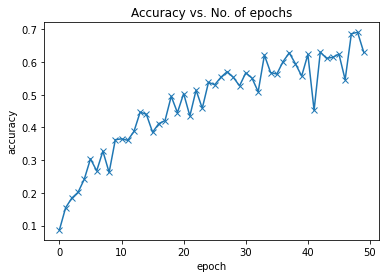

In [23]:
# Visualizing how our model performed after each epoch
accuracies_2 = [r['val_acc'] for r in history_2]
plt.plot(accuracies_2, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

The second model has the same trend as the previous model, higher amount of epochs lead to higher accuracy. The variability of the accuracy is still there but this model does not suffer from a large dip in accuracy. Let's train this model for 50 more epochs.

In [24]:
history_3 = fit(50, 1e-5, model_2, train_loader, val_loader)

Epoch [0], val_loss: 1.9098, val_acc: 0.7259
Epoch [1], val_loss: 2.3530, val_acc: 0.6722
Epoch [2], val_loss: 2.7303, val_acc: 0.6230
Epoch [3], val_loss: 2.6074, val_acc: 0.6530
Epoch [4], val_loss: 1.9150, val_acc: 0.6960
Epoch [5], val_loss: 2.4516, val_acc: 0.6593
Epoch [6], val_loss: 1.7031, val_acc: 0.7342
Epoch [7], val_loss: 2.7151, val_acc: 0.6354
Epoch [8], val_loss: 2.2343, val_acc: 0.6900
Epoch [9], val_loss: 1.4677, val_acc: 0.7454
Epoch [10], val_loss: 1.7679, val_acc: 0.7040
Epoch [11], val_loss: 1.6972, val_acc: 0.7357
Epoch [12], val_loss: 1.7417, val_acc: 0.7361
Epoch [13], val_loss: 1.6969, val_acc: 0.7082
Epoch [14], val_loss: 1.8569, val_acc: 0.7332
Epoch [15], val_loss: 1.8028, val_acc: 0.7110
Epoch [16], val_loss: 1.2110, val_acc: 0.7744
Epoch [17], val_loss: 1.1476, val_acc: 0.7970
Epoch [18], val_loss: 1.7200, val_acc: 0.7101
Epoch [19], val_loss: 1.3602, val_acc: 0.7586
Epoch [20], val_loss: 1.1352, val_acc: 0.7727
Epoch [21], val_loss: 1.4716, val_acc: 0.758

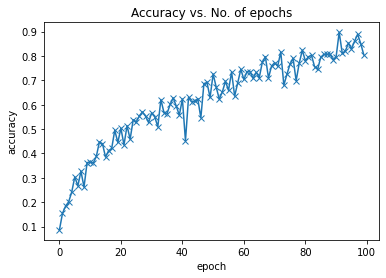

In [25]:
# Visualizing total performance of the model across 100 epoch
accuracies_3 = [r['val_acc'] for r in history_3]
accuracies_model2 = accuracies_2 + accuracies_3
plt.plot(accuracies_model2, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

From the graph, our model would most likely plateau at about 80%. By reducing the learning rate, we minimized the amount of dips in the accuracy of our model. This is most likely the limit of the accuracy of the model using logistic regression. Other models could also be used to implement a more sophisticated and accurate model. For now, let's test the accuracy of the model to the test dataset.

In [26]:
# Evaluate on test dataset
result_2 = evaluate(model_2, test_loader)
result_2

{'val_loss': 6.2635416984558105, 'val_acc': 0.5388020873069763}

The accuracy of model 2 is just slightly better than model 1. However, the major difference is their value loss. By decreasing the learning rate, we have also improved the accuracy of the probability distribution generated by the cross\_entropy function.

In [27]:
# Logging the metrics to jovian.ml
jovian.log_metrics(test_acc=result_2['val_acc'], test_loss=result_2['val_loss'])

[jovian] Metrics logged.


## Prediction
#### Using our model to predict the letter denoted by the hand symbol

Here we used a predict\_image helper function to use our second model to try and predict on some of the images on the test dataset.

In [29]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: H , Predicted: H


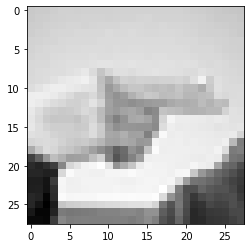

In [30]:
img, label = testdataset[919]
plt.imshow(img.reshape(28,28), cmap='gray')
print('Label:', letters[label.item()], ', Predicted:', letters[predict_image(img, model_2)])

Here the model correctly predicted the image. Let's try another one.

Label: H , Predicted: N


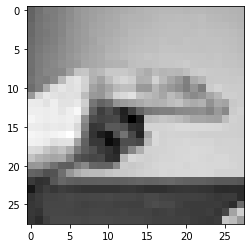

In [31]:
img, label = testdataset[19]
plt.imshow(img.reshape(28,28), cmap='gray')
print('Label:', letters[label.item()], ', Predicted:', letters[predict_image(img, model_2)])

Here the model incorrectly predicted the image. Probably because the image is dark on the center that's why the model thought that the image is corresponds the letter "N".

## Save and upload
#### Saving the parameters and code for future use

In [32]:
os.chdir('/kaggle/working/')
jovian.commit(project='mnist-logistic-minimal', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "gry-galario/mnist-logistic-minimal" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/gry-galario/mnist-logistic-minimal


'https://jovian.ml/gry-galario/mnist-logistic-minimal'

In [34]:
# Here the model parameters are saved so that we dont have to train the model next time
torch.save(model_2.state_dict(), 'mnist-logistic.pth')

In [35]:
# Let's look at the model parameters
model_2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0124,  0.0202, -0.0243,  ...,  0.0081,  0.0165, -0.0029],
                      [ 0.0251,  0.0169, -0.0093,  ...,  0.0270,  0.0185,  0.0027],
                      [-0.0250, -0.0077, -0.0101,  ..., -0.0308,  0.0293, -0.0089],
                      ...,
                      [ 0.0211,  0.0215, -0.0284,  ...,  0.0303, -0.0024,  0.0177],
                      [-0.0211,  0.0308, -0.0225,  ..., -0.0178, -0.0247, -0.0067],
                      [-0.0130, -0.0296,  0.0113,  ...,  0.0263, -0.0161, -0.0303]])),
             ('linear.bias',
              tensor([ 0.0224, -0.0150,  0.0261, -0.0233, -0.0051, -0.0003,  0.0332, -0.0190,
                      -0.0050, -0.0140,  0.0064,  0.0225, -0.0353,  0.0118,  0.0238, -0.0032,
                       0.0027, -0.0054, -0.0270,  0.0263,  0.0311,  0.0342, -0.0159, -0.0002,
                      -0.0219, -0.0200]))])

In [36]:
# To verify we can load these parameters in a new model
model_3 = MnistModel()
model_3.load_state_dict(torch.load('mnist-logistic.pth'))
model_3.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0124,  0.0202, -0.0243,  ...,  0.0081,  0.0165, -0.0029],
                      [ 0.0251,  0.0169, -0.0093,  ...,  0.0270,  0.0185,  0.0027],
                      [-0.0250, -0.0077, -0.0101,  ..., -0.0308,  0.0293, -0.0089],
                      ...,
                      [ 0.0211,  0.0215, -0.0284,  ...,  0.0303, -0.0024,  0.0177],
                      [-0.0211,  0.0308, -0.0225,  ..., -0.0178, -0.0247, -0.0067],
                      [-0.0130, -0.0296,  0.0113,  ...,  0.0263, -0.0161, -0.0303]])),
             ('linear.bias',
              tensor([ 0.0224, -0.0150,  0.0261, -0.0233, -0.0051, -0.0003,  0.0332, -0.0190,
                      -0.0050, -0.0140,  0.0064,  0.0225, -0.0353,  0.0118,  0.0238, -0.0032,
                       0.0027, -0.0054, -0.0270,  0.0263,  0.0311,  0.0342, -0.0159, -0.0002,
                      -0.0219, -0.0200]))])

Since the parameters for the model\_2 and model\_3 are the same, we can indeed load the saved parameters and no longer need to train the model again.

In [37]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "gry-galario/mnist-logistic-minimal" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/gry-galario/mnist-logistic-minimal


'https://jovian.ml/gry-galario/mnist-logistic-minimal'

# References
* Sign Language MNIST Dataset: https://www.kaggle.com/datamunge/sign-language-mnist
* Image Classification Using Logistic Regression: https://www.youtube.com/watch?v=4ZZrP68yXCI

In [ ]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
